In [8]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import pandas as pd
from matplotlib import cm
import matplotlib as mp
import matplotlib.colors as mcolors
import scipy.special as sc
import scipy.optimize as so
from matplotlib.colors import LinearSegmentedColormap


In [9]:
L=48
W=1
GI=100
DG=0.01
NI=100
NR=10
NF=1000
NS=1024
NNs=1
n_mean=90
start=0
method=3
model="QIM"
name_method="RBM"
norm = mcolors.Normalize(vmin=np.abs(NI), vmax=np.abs(NF))
name_figs="L"+str(L)+"W"+str(W)+"G"+str(GI)+"NN"+str(NNs)+"NS"+str(NS)+"NI"+str(NS)+"NF"+str(NF)+"E.png"

In [10]:
G=[i for i in range(NI,NF,NI)]
name=[ "M"+str(method)+"L"+str(L)+"W"+str(W)+"NS"+str(NS)+"NB"+str(NN)+"G"+str(GI)+"D.txt" for NN in G]
file=[ pd.read_csv(name[i],sep="\s+",dtype="a") for i in range(len(G)) ]
file=[ files.astype(float) for files in file] 

PDF=[np.zeros(L*W) for g in G]
DPDF=[np.zeros(L*W) for g in G]
for i in range(len(G)):
    PDF[i][0]=file[i]["D"][0]/NS
    PDF[i][0]=0
    DPDF[i][0]=file[i]["dD"][0]/NS
    for j in range(1,L*W):
        PDF[i][j]=(file[i]["D"][j]-file[i]["D"][j-1])/NS
        DPDF[i][j]=(file[i]["dD"][j]+file[i]["dD"][j-1])/NS
               

In [11]:
name_teo="M5L"+str(L)+"W"+str(W)+"NS"+str(1000)+"NR"+str(1000)+"G"+str(GI*10)+"D.txt"
file_teo=pd.read_csv(name_teo,sep="\s+",dtype="a")
file_teo=file_teo.astype(float)

PDF_teo=np.zeros(L*W)
DPDF_teo=np.zeros(L*W)
PDF_teo[0]=file_teo["D"][0]/NS
PDF_teo[0]=0
DPDF_teo[0]=file_teo["dD"][0]/NS

for j in range(1,L*W):
    PDF_teo[j]=(file_teo["D"][j]-file_teo["D"][j-1])/NS
    DPDF_teo[j]=(file_teo["dD"][j]+file_teo["dD"][j-1])/NS
               


FileNotFoundError: [Errno 2] No such file or directory: 'M5L48W1NS1000NR1000G1000D.txt'

In [ ]:
def exp_Ansatz(x, k, d, d0):
    import numpy as np

    x = np.array(x, dtype=float)
    d_aux = d * x + d0
    log_prob = np.log(k) * np.ones_like(x)  # Initialize log-probabilities

    for i, x_i in enumerate(x):
        for j in range(1, int(x_i) + 1):
            term = np.log(d_aux[i] + 1 - j) - np.log(j) - (d_aux[i] / x_i) * np.log(2)
            log_prob[i] += term

    # Convert back to probabilities
    prob = np.exp(log_prob)
    return prob


In [ ]:
def exp_Ansatz(x, k, d, d0):
    # Ensure x is a numpy array
    x = np.array(x, dtype=float)
    d_aux =d * x + d0
    prob = np.ones_like(x)  # Initialize an array for probabilities
    
    # Handle each element in x independently due to range(1, x_i + 1)
    for i, x_i in enumerate(x):
        for j in range(1, int(x_i) + 1):  # Loop from 1 to x_i (inclusive)
            prob[i] *= (d_aux[i] + 1 - j) / (j * 2 ** (d_aux[i] / x_i))
    
    return prob*k



def Ansatz(x, k, d, d0):
    
    EE=2**(d*x+d0)
    AA=k*sc.binom(d*x+d0,x*L)/EE     
    return AA
    #A=sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L + 1) - sc.gammaln(d*x+d0 - x*L + 1)-np.log(2)*(d*x+d0)

    #return np.exp(A,dtype=np.float64)
    
    
def log_Ansatz(x, k, d, d0):
    
    A=np.log(k)+sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L*W + 1) - sc.gammaln(d*x+d0 - x*L*W + 1)-np.log(2)*(d*x+d0)
    return A
    
    
def logKL(X,Y):
    return sum(map(lambda x: x[0]*np.log(x[0]/x[1]),zip(X,Y)))

def bounds(x,L):
    
    eps=10**(-6)
    #aux=x
    aux=np.array(x[0:int(L/2)])
    max=aux.argmax()
    return max


def initial_guess(x,L):
    eps=10**(-5)
    maxi=bounds(x,L)
    
    delta_left=maxi

    while delta_left>0 and x[delta_left]>eps:
        delta_left-=1
    delta_left+=1
    delta_right=maxi
    while delta_right<int(L*0.48) and x[delta_right]>eps:
        delta_right+=1
    delta_right-=1

    return [delta_left,maxi,delta_right]


def d(r,d0,d1,d2):
    return d0+r*d1+d2*(r**2)

def der_d(r,d0,d1,d2):
    return d1+2*r*d2

def grad_KL(r,d0,d1,d2):
    dr=d(r,d0,d1,d2)
    return -(sc.digamma(dr+1)-sc.digamma(dr-r*L+1)-dr/2)
    
def av_min(P,x,d0,d1,d2,n):
    sum=0
    for p in range(len(P)):
        aux=P[p]*grad_KL(x[p],d0,d1,d2)
        sum+=P[p]*grad_KL(x[p],d0,d1,d2)*(float(x[p])*1.0)**n
    return sum


def opt_step(P,x,k,d0,d1,d2,alp):
    
    
    d0_new=d0-alp*av_min(P,x,d0,d1,d2,0)
    d1_new=d1-alp*av_min(P,x,d0,d1,d2,1)
    d2_new=d2-alp*av_min(P,x,d0,d1,d2,2)
    k_new=k+alp*np.sum(P)/k
    
    return [k_new,d0_new,d1_new,d2_new]

def optimizer(P,k,d0,d1,d2,alp,N,alp_I,alp_F):
    
    KL=[]
    x=np.arange(alp_I,alp_F,1)/L
    k_aux=k
    d0_aux=d0
    d1_aux=d1
    d2_aux=d2
    print("initial",k,d0,d1,d2)
    for i in range(N):
        #print(d0_aux,d1_aux,d2_aux)
        aux=opt_step(P,x,k_aux,d0_aux,d1_aux,d2_aux,alp)
        k_aux=aux[0]
        d0_aux=aux[1]
        d1_aux=aux[2]
        d2_aux=aux[3]
        Y=Ansatz(x,k,d0_aux,d1_aux)
        KL.append(logKL(P,Y))
    print("d0","d1","d2")
    print(k_aux,d0_aux,d1_aux,d2_aux)
    return [KL,[k_aux,d0_aux,d1_aux,d2_aux]]
    
  
def fit(F,X,Y,guesses):
    Nd=len(guesses)
    Ntry=200
    KL=13
    RV=[X[0],X[len(X)-1]]
    min_points=15
    try:
        A=so.curve_fit(F,X,Y,p0=guesses)
        YY=F(X,*A[0])
        KL_try=logKL(Y/np.sum(Y),YY/np.sum(YY))
        bestA=A
        bestKL=KL_try
        bestRV=[0,len(X)-1]
    except:
        bestA=[np.array([np.nan for x in range(Nd)]),np.full((Nd,Nd),np.nan)]
        KL_try=np.nan
        bestKL=np.nan
        bestRV=RV
        
    
    if KL_try>0.0001:
        print("INSIDE")
        for i in range(Ntry):
            try:
                guesses[Nd-1]-=1
                X_test=X[:len(X)-i]
                Y_test=Y[:len(Y)-i]
                A=so.curve_fit(F,X_test,Y_test,p0=guesses)
                YY=F(X_test,A[0][0],A[0][1],A[0][2])
                KL_test=logKL(Y_test/np.sum(Y_test),YY/np.sum(YY))
                if (KL_test<bestKL or bestKL==np.nan) and len(Y_test)>min_points:
                    bestKL=KL_test
                    bestA=A
                    bestRV=[0,len(X)-i-1]
                    
                print(i,KL_test,bestKL,"interval=[",X[bestRV[0]],",",X[bestRV[1]],"]")
            except:
                continue
    print("final parameters:")
    print([bestA,bestKL,bestRV])
    return [bestA,bestKL,bestRV]

In [ ]:
teo_par=initial_guess(PDF_teo,L*W)
teo_init=[1.0,1.0,teo_par[1]]
x=np.arange(teo_par[0],teo_par[1],1,)
yy=PDF_teo[teo_par[0]:teo_par[1]]
teo_A,teo_KL_aux,teo_RV_aux=fit(exp_Ansatz,x,yy,teo_init)

#teo_A=so.curve_fit(exp_Ansatz,x,(PDF_teo[teo_par[0]:teo_par[1]]),p0=(teo_init[0],teo_init[1],teo_init[2]))
teo_ID0=[]
teo_DID0=[]
teo_ID0.append(teo_A[0])
teo_DID0.append(np.sqrt(np.diag(teo_A[1])))
teo_ID0=np.array(teo_ID0)
teo_DID0=np.array(teo_DID0)
print(teo_ID0)

In [5]:

colors = [(0.0, 'blue'),(0.25,"green"),(0.5, "brown"),(0.75, 'red'),(1.0,"yellow")]
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_blue_green', colors)

AA=[i for i in range(start,len(G))]
print(AA)
ID0=[]
DID0=[]
KL=[]
alp=0.5
for i in range(len(AA)):
    
    #par=initial_guess(PDF[AA[i]],L*W)
    par=[teo_par[0],teo_par[0]+teo_RV_aux[1],teo_par[0]+teo_RV_aux[1]]
    #print(par[0],par[2])
    #print(PDF[AA[i]][par[0]:par[2]])
    
    #A=optimizer(PDF[AA[i]][par[0]:par[2]],1.0,par[1],1,0.001,alp,N,par[0],par[2])
 
    #x=np.arange(par[0],par[2],1,)/(L*W)
    x=np.arange(par[0],par[2],1,)
    yy=PDF[AA[i]][par[0]:par[2]]
    eps=10**(-3)
    init_0=[1.0,1.0,par[1]]
    #A,KL_aux,RV_aux=fit(exp_Ansatz,x,yy,init_0)
    A=so.curve_fit(exp_Ansatz,x,(PDF[AA[i]][par[0]:par[1]]),p0=(init_0[0],init_0[1],init_0[2]))
    YY=exp_Ansatz(x,A[0][0],A[0][1],A[0][2])
    KL_aux=logKL(yy/np.sum(yy),YY/np.sum(YY))
    
    ID0.append(A[0])
    DID0.append(np.sqrt(np.diag(A[1])))
    KL.append(KL_aux)

ID0=np.array(ID0)
DID0=np.array(DID0)
KL=np.array(KL)

#fig,axis=plt.subplots(1,1,figsize=(7,5))
#plt.title("Model evaluation for different values of $h/J$",fontsize=15)
#plt.xlabel("Hamming Distance $r$",fontsize=15)
#plt.ylabel("P(r)",fontsize=15)
#plt.yscale("log")
#plt.ylim([1e-6,1e-1])
for i in range(0,len(AA)):
    fig,axis=plt.subplots(1,1,figsize=(7,5))
    plt.title("Model evaluation for different values of $N_{run}\; h/J="+str(GI*DG)+"$",fontsize=15)
    plt.xlabel("Hamming Distance $r$",fontsize=15)
    plt.ylabel("P(r)",fontsize=15)
    plt.yscale("log")
    #plt.ylim([1e-6,1e-1])
    par=initial_guess(PDF[AA[i]],L*W)
    #x=np.arange(par[0],par[2],1)/(L*W)
    x=np.arange(par[0],par[1],1)
    #print(ID0[i,:])
    #print(DID0[i,:])
    #y=log_Ansatz(x,ID0[i,0],ID0[i,1],ID0[i,2])
    #y=np.exp(y)
    y=exp_Ansatz(x,ID0[i,0],ID0[i,1],ID0[i,2])
    axis.axvline(x=par[1],linestyle="dashed")
    #print("y....")
    #print(np.exp(y))
    #axis.plot(x,y,color=cmap(norm(G[AA[i]])),label=str(np.round(0.01*G[AA[i]],2)))
    axis.plot(x,y,color="black",label=str(np.round(0.01*G[AA[i]],2)))
    axis.scatter(x,PDF[AA[i]][par[0]:par[1]],color=cmap(norm(G[AA[i]])))
#plt.legend(bbox_to_anchor=[1.0, 1.0])
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
# Create the colorbar
    cbar = plt.colorbar(sm,ax=axis,label='$N_{run}$')
    cbar.set_label('$N_{run}$', fontsize=14)
    plt.legend()
    plt.savefig("validation"+str(i)+name_figs)
    plt.show()

xx=[1/G[a] for a in AA]
plt.figure()
plt.title( r"$\%$"+"BID for different values of $N_{run}$ \n $L="+str(L)+"$ $N_{snapshots}="+str(NS)+"\; h/J="+str(GI*DG)+"$",fontsize=15)
plt.xlabel(" $1/N_{run}$",fontsize=15)
plt.ylabel("$\% d_0$",fontsize=15)
plt.xscale("log")
plt.errorbar(xx,np.abs(ID0[:,2]-teo_ID0[0,2])/teo_ID0[0,2],yerr=DID0[:,2]/teo_ID0[0,2],linestyle="dashed")
plt.scatter(xx,np.abs(ID0[:,2]-teo_ID0[0,2])/teo_ID0[0,2],color="black")
plt.legend()
plt.savefig("BID"+name_figs)

plt.show()

plt.figure()
plt.title(r"$ \% d_1$ "+"for different values of $N_{run}$ \n $L="+str(L)+"$ $N_{snapshots}="+str(NS)+"\; h/J="+str(GI*DG)+"$",fontsize=15)
plt.xlabel(" $1/N_{run}$",fontsize=15)
plt.ylabel("$\% d_1$",fontsize=15)
plt.xscale("log")
plt.errorbar(xx,np.abs(ID0[:,1]-teo_ID0[0,1])/teo_ID0[0,1],yerr=DID0[:,1]/teo_ID0[0,1],color="green",linestyle="dashed")
plt.scatter(xx,np.abs(ID0[:,1]-teo_ID0[0,1])/teo_ID0[0,1],color="black")
plt.legend()
plt.savefig("D1"+name_figs)
plt.show()


plt.figure()
plt.title("$D_{KL}$ for different values of $N_{run}$ \n $L="+str(L)+"$ $N_{snapshots}="+str(NS)+"\; h/J="+str(GI*DG)+"$",fontsize=15)
plt.xlabel(" $1/N_{run}$",fontsize=15)
plt.ylabel("$D_{KL}$",fontsize=15)
plt.xscale("log")
plt.plot(xx,KL,color="green",linestyle="dashed")
plt.scatter(xx,KL,color="black")
plt.legend()
plt.savefig("DKL"+name_figs)

plt.show()



[0, 1, 2, 3, 4, 5, 6, 7, 8]


NameError: name 'teo_par' is not defined

NameError: name 'PDF_teo' is not defined

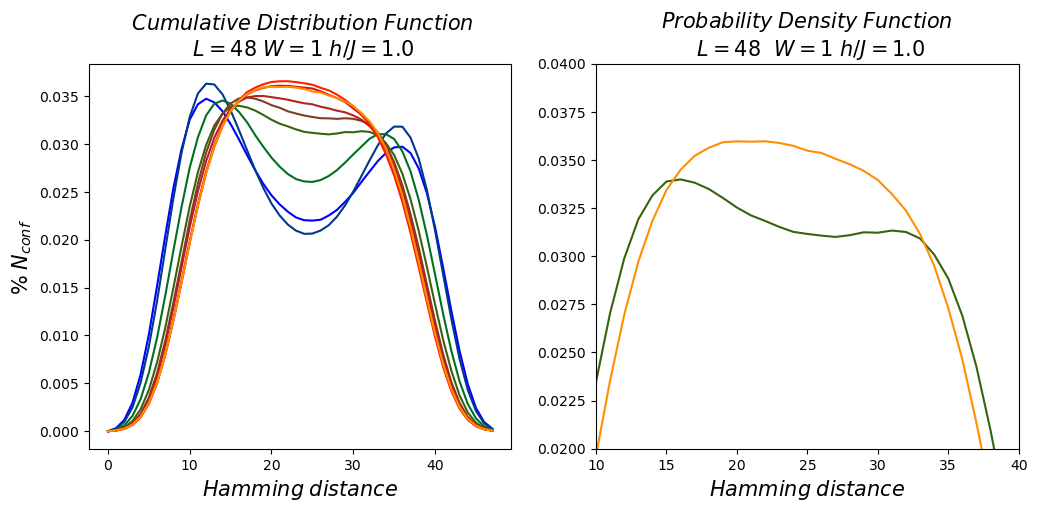

In [6]:
x=np.arange(0,L*W,1)
fig,axis=plt.subplots(1,2,figsize=(12,5))

axis[0].set_title(r'$ \;Cumulative \; Distribution \; Function $ '+"\n"+r" $L="+str(L)+"$"+" $W="+str(W)+"$"+" $h/J="+str(GI*DG)+"$",fontsize=15)
axis[1].set_title(r'$Probability \; Density \; Function$ '+"\n"+r" $L="+str(L)+"$ "+" $W="+str(W)+"$"+" $h/J="+str(GI*DG)+"$",fontsize=15)
axis[0].set_xlabel("$Hamming\; distance$",fontsize=15)
axis[1].set_xlabel("$Hamming\; distance$",fontsize=15)
axis[0].set_ylabel("$\% \;N_{conf}$",fontsize=15)
axis[1].set_ylim([0.02,0.04])
axis[1].set_xlim([10,40])

for i in range(0,len(G)):
    #plt.xscale("log")
    #plt.yscale("log")
    #t=axis[0].errorbar(x,file[i]["D"]/NS,yerr=file[i]["dD"]/NS,color=cmap(norm(G[i])),label="$NL"+str(G[i])+"$")
    #axis[1].errorbar(x,PDF[i],yerr=DPDF[i],color=cmap(norm(G[i])),label="$NL"+str(G[i])+"$")
    a=cmap(norm(G[i]))
    #t=axis[1].errorbar(x,file[i]["D"]/NS,color=a,label="$NL"+str(G[i])+"$")
    if i==3 or i==len(G)-1:
        t=axis[1].errorbar(x,PDF[i],color=a,label="$NL"+str(G[i])+"$")
    axis[0].errorbar(x,PDF[i],color=a,label="$NL"+str(G[i])+"$")

axis[0].errorbar(x,PDF_teo,linestyle="dashed",color="black")
axis[1].errorbar(x,PDF_teo,linestyle="dashed",color="black")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
# Create the colorbar
cbar = plt.colorbar(sm, ax=axis, label='$NR$')
cbar.set_label('$NR$', fontsize=14)
plt.savefig(name_figs+"Hamming_distance.png")
plt.show()




In [ ]:
#D_KL from Exact to RBM of the Hamming Distributions
#D_KL of the BID fit


In [ ]:
eps=10**(-16)
KL_it=[]
for i in range(0,len(G)):
    aux=np.array(PDF[i])
    KL_it.append(logKL(PDF_teo[PDF_teo>eps]/np.sum(PDF_teo[PDF_teo>eps]),aux[PDF_teo>eps]/np.sum(aux[PDF_teo>eps])))

NameError: name 'xx' is not defined

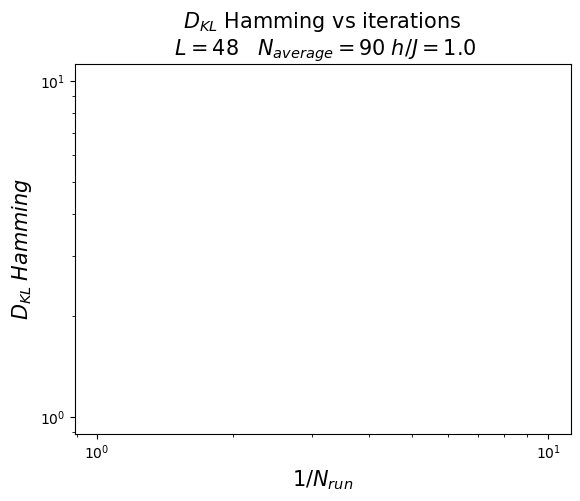

In [7]:
plt.figure()
plt.title(r"$D_{KL}$ Hamming vs iterations"+"\n"+r" $L="+str(L)+"$ "+r" $\; N_{average}="+str(n_mean)+"$"+r"$\;h/J="+str(GI*0.01)+"$",fontsize=15)
plt.xlabel("$1/N_{run}$",fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("$D_{KL}\; Hamming$",fontsize=15)
plt.plot(xx,KL_it)
plt.scatter(xx,KL_it)
plt.savefig("DKL_Hamming.png")